In [8]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
from matplotlib.colors import ListedColormap
import sklearn.neighbors
import sklearn.cross_validation
import sklearn.metrics
import sklearn.lda
import sklearn.svm
import sklearn.linear_model

n=100

def make_class_data(mean=[50,110],multiplier=1.5,var=[[10,10],[10,10]],cor=-0.4,N=100):
    """
    generate a synthetic classification data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var1=numpy.array([[var[0][0],0],[0,var[0][1]]])
    cov1=var1.dot(cor).dot(var1)
    d1=numpy.random.multivariate_normal(mean,cov1,int(N/2))
    var2=numpy.array([[var[1][0],0],[0,var[1][1]]])
    cov2=var2.dot(cor).dot(var2)
    d2=numpy.random.multivariate_normal(numpy.array(mean)*multiplier,cov2,int(N/2))
    d=numpy.vstack((d1,d2))
    cl=numpy.zeros(N)
    cl[:(N/2)]=1
    return cl,d

[  50.24866022  109.10337545]
[  55.44383732  119.91339275]


/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


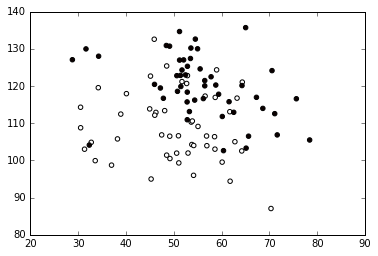

In [9]:
cl,d=make_class_data(multiplier=[1.1,1.1],N=n)
print(numpy.mean(d[:50,:],0))
print(numpy.mean(d[50:,:],0))

plt.scatter(d[:,0],d[:,1],c=cl,cmap=matplotlib.cm.hot)

Now let's look at some classification methods. 

####Nearest Neighbor

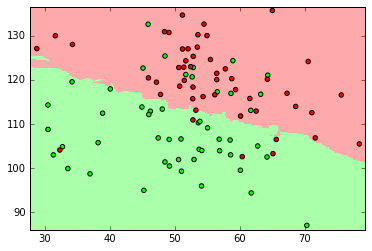

In [10]:
# adapted from http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#example-neighbors-plot-classification-py

n_neighbors = 30

 # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(d, cl)

def plot_cls_with_decision_surface(d,cl,clf,h = .25 ):
    """Plot the decision boundary. For that, we will assign a color to each
    point in the mesh [x_min, m_max]x[y_min, y_max].
    h= step size in the grid
    """
    x_min, x_max = d[:, 0].min() - 1, d[:, 0].max() + 1
    y_min, y_max = d[:, 1].min() - 1, d[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                         numpy.arange(y_min, y_max, h))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(d[:, 0], d[:, 1], c=cl, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

plot_cls_with_decision_surface(d,cl,clf)

__Exercise:__ Change the number of nearest neighbors and see how it changes the surface.

Now let's write a function to perform cross-validation and compute prediction accuracy.


In [11]:

def classify(d,cl,clf,cv):
    pred=numpy.zeros(n)
    for train,test in cv:
        clf.fit(d[train,:],cl[train])
        pred[test]=clf.predict(d[test,:])
    return sklearn.metrics.accuracy_score(cl,pred),sklearn.metrics.confusion_matrix(cl,pred)



In [12]:
clf=sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
# use stratified k-fold crossvalidation, which keeps the proportion of classes roughly
# equal across folds
cv=sklearn.cross_validation.StratifiedKFold(cl, 8)
acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)

accuracy = 0.820000
confusion matrix:
[[45  5]
 [13 37]]


__Exercise:__  Loop through different levels of n_neighbors (from 1 to 30) and compute the accuracy.

Now write a loop that does this using 100 different randomly generated datasets, and plot the mean across datasets.  This will take a couple of minutes to run.

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


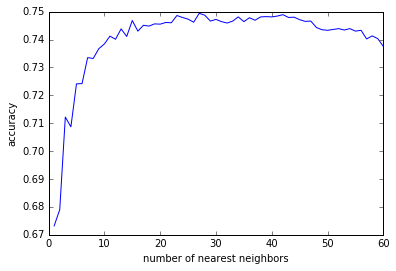

In [13]:
nn_range = range(1,61)

accuracy_knn=numpy.zeros((100,len(nn_range)))
for x in range(100):
    ds_cl,ds_x=make_class_data(multiplier=[1.1,1.1],N=n)
    ds_cv=sklearn.cross_validation.StratifiedKFold(ds_cl, 8)
    for i in nn_range:
        clf=sklearn.neighbors.KNeighborsClassifier(i, weights='uniform')
        accuracy_knn[x,i-1],_=classify(ds_x,ds_cl,clf,ds_cv)
plt.plot(nn_range,numpy.mean(accuracy_knn,0))
plt.xlabel('number of nearest neighbors')
plt.ylabel('accuracy')

#### Linear discriminant analysis

accuracy = 0.800000
confusion matrix:
[[42  8]
 [12 38]]


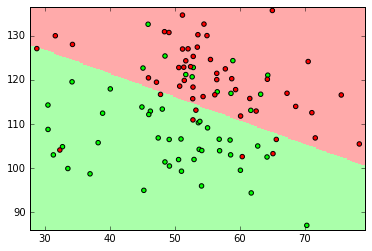

In [14]:
clf=sklearn.lda.LDA()
cv=sklearn.cross_validation.LeaveOneOut(n)
acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)
plot_cls_with_decision_surface(d,cl,clf)

#### Logistic regression


accuracy = 0.570000
confusion matrix:
[[45  5]
 [38 12]]


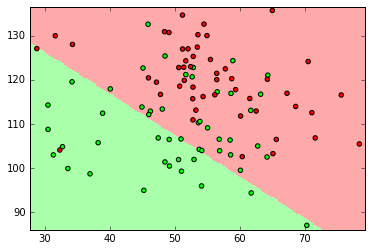

In [15]:
clf=sklearn.linear_model.LogisticRegression(C=0.5)
acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)
plot_cls_with_decision_surface(d,cl,clf)

#### Support vector machines

accuracy = 0.800000
confusion matrix:
[[42  8]
 [12 38]]


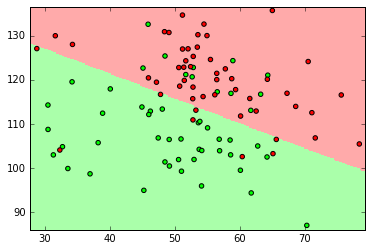

In [16]:
clf=sklearn.svm.SVC(kernel='linear')
acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)
plot_cls_with_decision_surface(d,cl,clf)

__Exercise:__ Implement the example above using a nonlinear SVM with a radial basis kernel.

__Exercise:__ Try the RBF SVC using a range of values for the gamma parameter.  
NOTE: For real data analysis, you cannot determine the best value of gamma this way, because you would be peeking at the test data which will make your results overly optimistic.  Instead, you would need to use nested cross-validation loops; we will come to this later

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/sklearn/svm/base.py:85: DeprecationWarning: gamma=0.0 has been deprecated in favor of gamma='auto' as of 0.17. Backward compatibility for gamma=0.0 will be removed in 0.18
  DeprecationWarning)


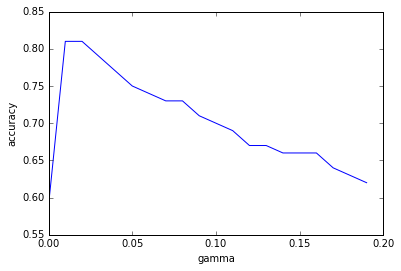

In [17]:
gammavals=numpy.arange(0.0,0.2,0.01)
accuracy_rbf=numpy.zeros(len(gammavals))
for i in range(len(gammavals)):
    clf=sklearn.svm.SVC(kernel='rbf',gamma=gammavals[i])
    accuracy_rbf[i],_=classify(d,cl,clf,cv)
plt.plot(gammavals,accuracy_rbf)
plt.xlabel('gamma')
plt.ylabel('accuracy')

Plot the boundary for the classifier with the best performance

Best gamma: 0.010000
Accuracy: 0.810000


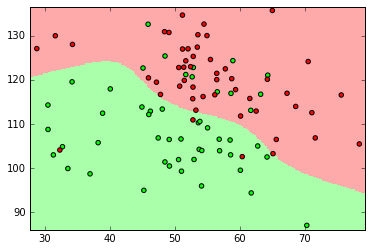

In [18]:
maxgamma=gammavals[numpy.where(accuracy_rbf==numpy.max(accuracy_rbf))]
if len(maxgamma)>1:
    maxgamma=maxgamma[0]
print('Best gamma: %f'%maxgamma)
clf=sklearn.svm.SVC(kernel='rbf',gamma=maxgamma)
acc,_=classify(d,cl,clf,cv)
print('Accuracy: %f'%acc)
plot_cls_with_decision_surface(d,cl,clf)